<a href="https://colab.research.google.com/github/margaridaatedim/dlnn_waldo_group_2/blob/adjustments_in_notebook/Binary_Classification_Wally_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Where's Waldo

A project by Group #02:
* António Martins (20211369)
* Clara Barreto (20211768)
* Larissa Cayres de Lucia (20211138)
* Lúcio Roque do Rosário (20180830)
* Margarida Tedim (20201358)

##Data Acquisition

In [1]:
#Install Kaggle package 
#!pip install kaggle

In [2]:
# Import the file kaggle.json from your local machine 
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"margaridatedim","key":"78f9194b91533c6d9ab14fbcf64b802b"}'}

In [3]:
# Create the necessary directory for the Kaggle API
! mkdir  ~/.kaggle

# Move the kaggle.json file to this folder
! cp kaggle.json  ~/.kaggle/

# Set the permissions for the JSON file to 600
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download kaggle dataset 
!kaggle datasets download -d residentmario/wheres-waldo

 99% 245M/248M [00:11<00:00, 24.8MB/s]
100% 248M/248M [00:11<00:00, 22.2MB/s]


In [5]:
# Unzip the Wheres-Wally dataset
! unzip wheres-waldo.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_6.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_7.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_8.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_9.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_0.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_1.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_10.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_11.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_12.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_13.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_14.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_15.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_2.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_3.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_4.jpg  
  inflating: wheres-

## Data Exploration 

### Import needed libaries



In [6]:
# Import the needed packages

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from PIL import Image
import io
import os, glob
import time
import random

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import zipfile
import shutil
from shutil import copyfile

import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

###  Visualization of the Data at different levels of resolution

Text(0.5, 1.0, '64-gray')

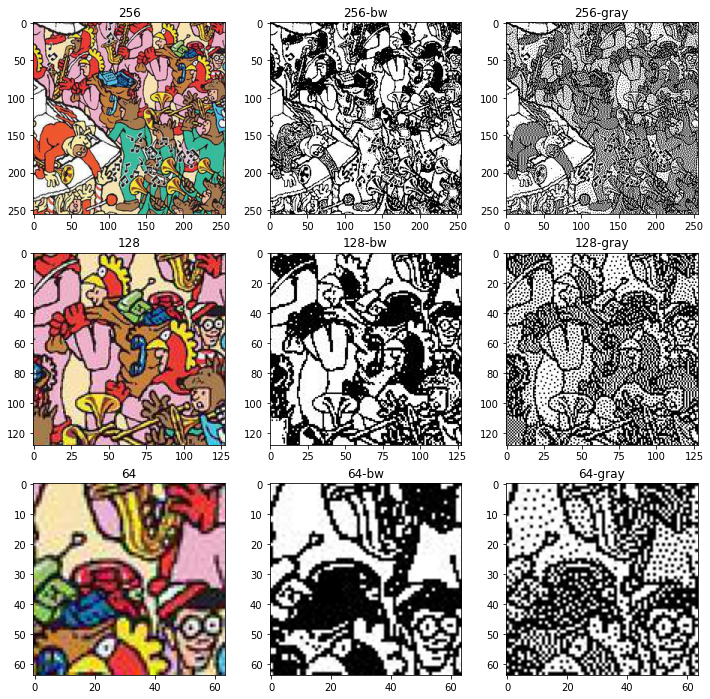

In [7]:
# Plot illustrating the same scene with Waldo at different levels of resolution: 256x256, 128x128, and 64x64: the dataset contains the same scenes at different levels of detail, or "close-up" views:

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))

im = plt.imread("wheres-waldo/Hey-Waldo/256/waldo/10_3_1.jpg")
axarr[0][0].imshow(im)
axarr[0][0].set_title("256")

im = plt.imread("wheres-waldo/Hey-Waldo/256-bw/waldo/10_3_1.jpg")
axarr[0][1].imshow(im)
axarr[0][1].set_title("256-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/256-gray/waldo/10_3_1.jpg")
axarr[0][2].imshow(im)
axarr[0][2].set_title("256-gray")

im = plt.imread("wheres-waldo/Hey-Waldo/128/waldo/10_7_2.jpg")
axarr[1][0].imshow(im)
axarr[1][0].set_title("128")

im = plt.imread("wheres-waldo/Hey-Waldo/128-bw/waldo/10_7_2.jpg")
axarr[1][1].imshow(im)
axarr[1][1].set_title("128-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/128-gray/waldo/10_7_2.jpg")
axarr[1][2].imshow(im)
axarr[1][2].set_title("128-gray")

im = plt.imread("wheres-waldo/Hey-Waldo/64/waldo/10_15_4.jpg")
axarr[2][0].imshow(im)
axarr[2][0].set_title("64")

im = plt.imread("wheres-waldo/Hey-Waldo/64-bw/waldo/10_15_4.jpg")
axarr[2][1].imshow(im)
axarr[2][1].set_title("64-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/64-gray/waldo/10_15_4.jpg")
axarr[2][2].imshow(im)
axarr[2][2].set_title("64-gray")

### Visualisation of the Classes Distribution



In [8]:
# Analyze the distribution of the classes in each of the datasets

def count_files(ls_folders, lookat):
  
  main_ls = [] # empty list to store the results of each folder   
  ls = [] # empty list to store the results of each subfolder  
  wdir = lookat
  

  for folder in ls_folders:
    # Count Waldos
    pathwaldo = wdir + folder + "/" + 'waldo'
    # Start the count of files in 0 
    file_waldo_count = 0
    # Read the archives and folders in the given path 
    for root, dirs, files in os.walk(pathwaldo):
      # Add the number of archives in the folder to the count 
      file_waldo_count += len(files)
  
    # Count not Waldos
    pathnotwaldo = wdir + folder + "/" + 'notwaldo'
    # Start the count of files in 0 
    file_notwaldo_count = 0
    # Read the archives and folders in the given path 
    for root, dirs, files in os.walk(pathnotwaldo):
      # Add the number of archives in the folder to the count 
      file_notwaldo_count += len(files)

    # Save the individual informations in the folder  
    ls.append(folder)
    ls.append(file_waldo_count)
    ls.append(file_notwaldo_count)
    # Add the main list 
    main_ls.append(ls)
    ls = []
  return main_ls


In [9]:
# Execute previous defined function on the Waldo dataset
data = count_files(os.listdir("wheres-waldo/Hey-Waldo/"), "wheres-waldo/Hey-Waldo/")

In [10]:
# Create a dataframe using the list of the lists specifying the columns names 
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Show the dataframe
print(df)

        Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0              128      27      1317          1344            0.02
8           128-bw      27      1317          1344            0.02
6         128-gray      27      1317          1344            0.02
2              256      31       286           317            0.10
3           256-bw      31       286           317            0.10
1         256-gray      31       286           317            0.10
9               64      39      5337          5376            0.01
7            64-bw      38      5043          5081            0.01
5          64-gray      38      5338          5376            0.01
4  original-images       0         0             0             NaN


### Add new images of Waldo 

In [11]:
# Delete all waldo images
dir = '/content/wheres-waldo/Hey-Waldo/128/waldo'
for file in os.scandir(dir):
    os.remove(file.path)

In [12]:
# Download extra waldo images from github
!wget --no-check-certificate \
    "https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldomerge.zip" \
    -O "/content/waldomerge.zip"

--2023-01-10 18:54:32--  https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldomerge.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldomerge.zip [following]
--2023-01-10 18:54:33--  https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldomerge.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4341396 (4.1M) [application/zip]
Saving to: ‘/content/waldomerge.zip’

/content/waldomerge 100%[===================>]   4.14M  --.-KB/s    in 0.01s   

2023-01-10 18:54:33 (353 MB/s) - ‘/content/waldomerge.zip’ saved [

In [13]:
zip_ref = zipfile.ZipFile('/content/waldomerge.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /content folder
zip_ref.close()

In [14]:
dir = '/content/waldomerge'
for file in os.scandir(dir):
    shutil.move(file.path, "/content/wheres-waldo/Hey-Waldo/128/waldo")

### Data Augmentation

In [15]:
# Data Augmentation: 4 transformations from the original Waldo images
datagen = ImageDataGenerator(rotation_range=40,
                             shear_range=40,
                             channel_shift_range=80,
                             horizontal_flip=True)

In [16]:
# Apply transformations and save each image to the output folder
folder = '/content/wheres-waldo/Hey-Waldo/128/waldo/'

#image_list = []
for j in os.listdir(folder):
  img = load_img(folder+j)  # this is a PIL image
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  # the .flow() command below generates batches of randomly transformed images
  # and saves the results to the `preview/` directory
  i = 0
  for batch in datagen.flow(
      x, batch_size=1, 
      save_to_dir='/content/wheres-waldo/Hey-Waldo/128/waldo',
      save_prefix='new_waldo', 
      save_format='jpeg'):
    i += 1
    if i > 3:
        break  # otherwise the generator would loop indefinitely
  
  #image_list.append(x)

In [17]:
# Create Zip File to check data augmentation output (Not Necessary)
# !zip -r /content/wheres-waldo/Hey-Waldo/128/waldo.zip /content/wheres-waldo/Hey-Waldo/128/waldo

In [18]:
# Download the created Zip File with the data augmentation images for quality control (Not Necessary)
# files.download('/content/wheres-waldo/Hey-Waldo/128/waldo.zip')

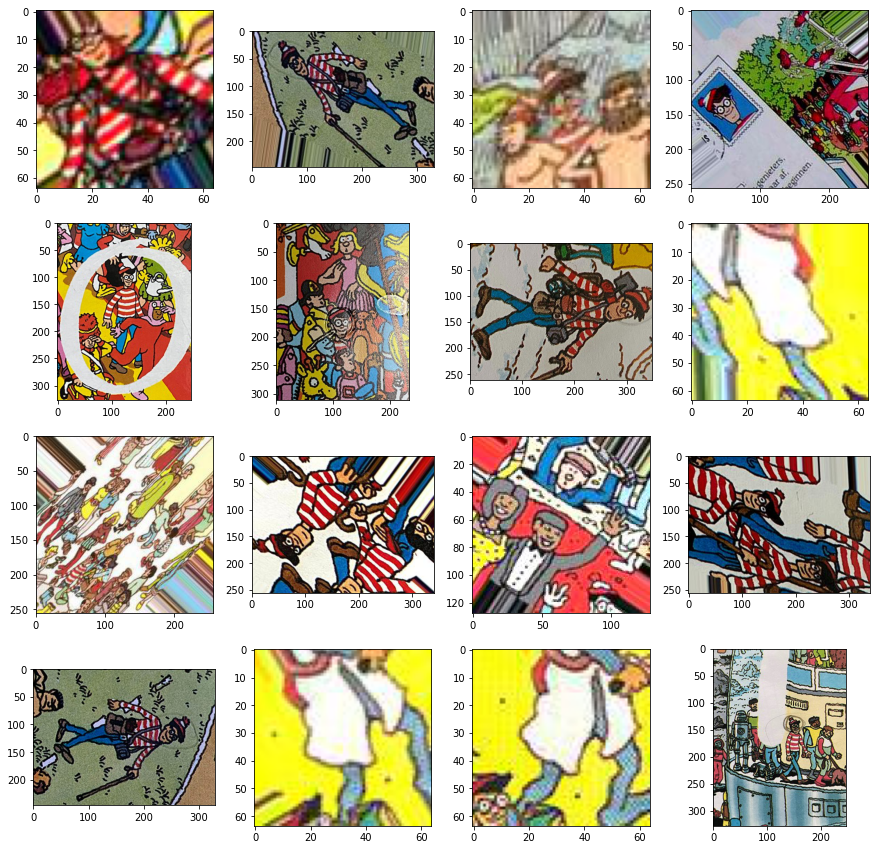

In [19]:
# Display the transformations applied by the data augmentation process

#newaldos_folder = '/content/sample_data/Waldo_test' #to change to 'wheres-waldo/Hey-Waldo/128/waldo/'
newaldos_folder = '/content/wheres-waldo/Hey-Waldo/128/waldo'

images = []
#for folder in os.listdir(nwaldos_folder):
for image in os.listdir(newaldos_folder + '/'):
  images.append(os.path.join(newaldos_folder, image))

plt.figure(1, figsize=(15, 15))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  #plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [20]:
# Execute previous defined function on the Waldo dataset
data = count_files(os.listdir("wheres-waldo/Hey-Waldo/"), "wheres-waldo/Hey-Waldo/")

In [21]:
# Create a dataframe using the list of the lists specifying the columns names 
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Show the dataframe
print(df)

        Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0              128     641      1317          1958            0.33
8           128-bw      27      1317          1344            0.02
6         128-gray      27      1317          1344            0.02
2              256      31       286           317            0.10
3           256-bw      31       286           317            0.10
1         256-gray      31       286           317            0.10
9               64      39      5337          5376            0.01
7            64-bw      38      5043          5081            0.01
5          64-gray      38      5338          5376            0.01
4  original-images       0         0             0             NaN


## Data Preprocessing 

### Train and Validation Split 

In [22]:
# Create a particular structure of directories

# Setting seed for ramdom
seed = 0
#tf.keras.utils.set_random_seed(seed)

# List of class names [should be the same of subfolder - class name]
classes = ['notwaldo', 'waldo']

# List of datasets 
datasets = ['128', '64', '256']

# Set the percentage of files to move to train dataset
percentage = 0.8

# Loop through the datasets
for ds in datasets:
  # Loop through the classes
  for c in classes:
    # Set the source directory 
    src_dir = 'wheres-waldo/Hey-Waldo/' + ds + '/' + c

    # Set the base path for the new directories
    base_path = 'wheres-waldo/data/' + ds

    # Set the list of new directory names
    dir_names = ['training_data/' + c, 'validation_data/' + c]

    ## part 1: creating test and train directories 
    for dir_name in dir_names:
      # Create the full path for the new directory
      dir_path = os.path.join(base_path, dir_name)

      if os.path.isdir(dir_path):
        print("The directory " + dir_name + " already exists!")
      else:
        # Create the new directory, including any intermediate directories
        os.makedirs(dir_path)
        print("New directory created " + dir_name)

    ## part 2: moving files 

    # Get a list of all the files in the source directory
    files = os.listdir(src_dir)

    # Shuffle the list of files
    random.shuffle(files)

    # Calculate the number of files to move
    num_files = int(len(files) * percentage)

    # Move the first num_files files to the first destination directory
    for i in range(num_files):
      src_path = os.path.join(src_dir, files[i])
      dst_path = os.path.join(os.path.join(base_path, dir_names[0]), files[i])
      shutil.move(src_path, dst_path)

    # Move the remaining files to the second destination directory
    for i in range(num_files, len(files)):
      src_path = os.path.join(src_dir, files[i])
      dst_path = os.path.join(os.path.join(base_path, dir_names[1]), files[i])
      shutil.move(src_path, dst_path)

New directory created training_data/notwaldo
New directory created validation_data/notwaldo
New directory created training_data/waldo
New directory created validation_data/waldo
New directory created training_data/notwaldo
New directory created validation_data/notwaldo
New directory created training_data/waldo
New directory created validation_data/waldo
New directory created training_data/notwaldo
New directory created validation_data/notwaldo
New directory created training_data/waldo
New directory created validation_data/waldo


### Visualisation of the Classes Distribution



In [23]:
# Execute previous defined function considering new folder structure
data = count_files(os.listdir("wheres-waldo/data/128/"), "wheres-waldo/data/128/")

In [24]:
# Cria o dataframe a partir da lista de listas, especificando os nomes das colunas
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Exibe o dataframe criado
print(df)

        Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0    training_data     512      1053          1565            0.33
1  validation_data     129       264           393            0.33


### Visualization of a Sample of Images



In [25]:
# Function to retrive a sample of images from the directories
def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

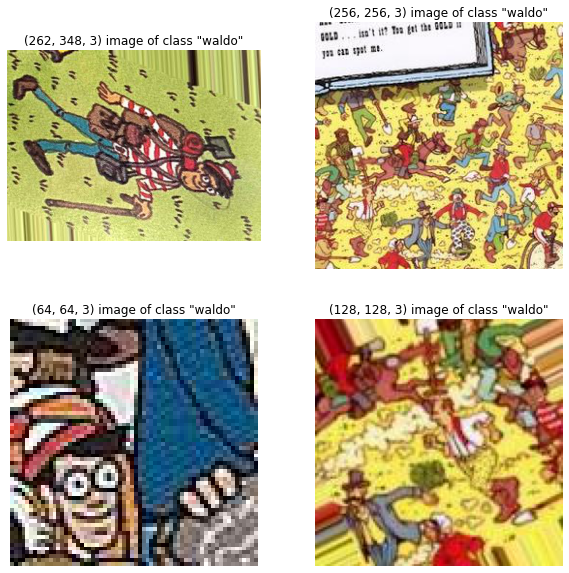

In [26]:
# Visualize a sample of "Waldo" images stored in the "training data" directory
show_sample_images("wheres-waldo/data/128/training_data/", "waldo")

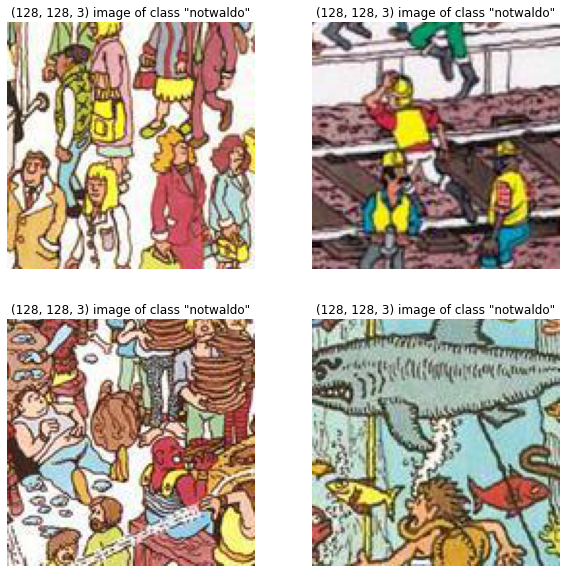

In [27]:
# Visualize a sample of "Not Waldo" images stored in the "training data" directory
show_sample_images("wheres-waldo/data/128/training_data/", "notwaldo")

### Creation of Tensors

In [28]:
## Tensor Configuration

#tf.keras.utils.set_random_seed(seed)
seed = 47

# Image type parameters 
image_size=(128, 128)
color_mode='rgb'

# The number of images to include in each batch when training the model
batch_size= 128 # 64 128 256

# Shuffle parameter
shuffle=True

# Labels parameters 
labels = 'inferred'
label_mode="binary"
names = ['notwaldo', 'waldo']

# If resized keep the same width and height ratio as the original image
crop_to_aspect_ratio = True

#### Convert Image to Tensor

In [29]:
# Create training_folder and testing_folder variables to store the path of the directories
training_folder = 'wheres-waldo/data/128/training_data'
validation_folder = 'wheres-waldo/data/128/validation_data'

In [30]:
# Generate an object of type tf.data.Dataset for training dataset
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

Found 1565 files belonging to 2 classes.


In [31]:
# Generate an object of type tf.data.Dataset for validation dataset
ds_val = image_dataset_from_directory(validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

Found 393 files belonging to 2 classes.


#### Visualization of a Sample of Images from Tensors

In [32]:
# Function to retrive a batch of images from the Tensors
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

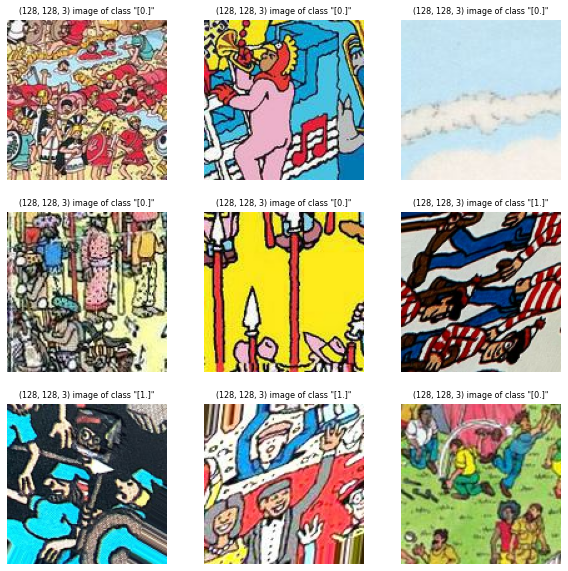

In [33]:
# Visualize a batch of images from Tensor "ds_train"
show_sample_batch(ds_train)

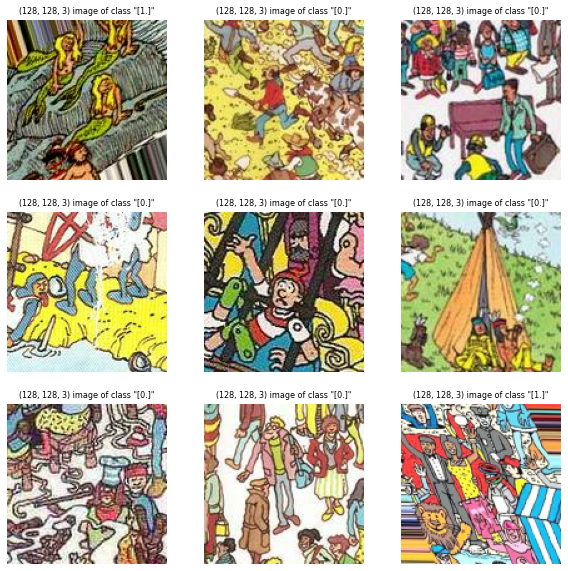

In [34]:
# Visualize a batch of images from Tensor "ds_val"
show_sample_batch(ds_val)

## Data Modeling

### Defining Input shape from BatchDataset Tensor

In [35]:
# Create a batch from an instance of the tf.data.Dataset ds_train
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(128, 128, 128, 3) (128, 1)

Sample of y_train: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(5, 1), dtype=float32)
Sample average of y_train: tf.Tensor(0.3125, shape=(), dtype=float32)


In [36]:
# Define Input Shape to be used in all the tested models
input_shape = batch_x_train.shape

### Base models definition

#### LeNet architecture

In [37]:
# General parameters for LeNet architecture
kernel_size = (5, 5) 
pool_size = (2, 2)

##### cnn_basemodel_0

In [38]:
# Model with CNN architecture with 2 convolutional layers (desc); the following cnn models deviate from this one in only one defined aspect

#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_0 = Sequential([
                  layers.Rescaling(1.0 / 255),

                  layers.Conv2D(filters=16, kernel_size=kernel_size,
                                kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                  layers.Activation("relu"),
                  layers.MaxPooling2D(pool_size=pool_size),

                  layers.Conv2D(filters=16, kernel_size=kernel_size,
                                kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                  layers.Activation("relu"),
                  layers.MaxPooling2D(pool_size=pool_size),

                  layers.Flatten(),
                  
                  layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_0.build(input_shape)

cnn_basemodel_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (128, 128, 128, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 124, 124, 16)       1216      
                                                                 
 activation (Activation)     (128, 124, 124, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (128, 62, 62, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 58, 58, 16)         6416      
                                                                 
 activation_1 (Activation)   (128, 58, 58, 16)         0         
                                                        

##### cnn_basemodel_1

In [39]:
# Model with LeNet architecture similar to model _0 with 2 convolutional layers but with 32 filters each instead of 16

#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_1 = Sequential([
                   layers.Rescaling(1.0 / 255),
                              
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Flatten(),
                   
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_1.build(input_shape)

cnn_basemodel_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_2 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (128, 58, 58, 32)         25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (128, 29, 29, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (128, 26912)             

##### cnn_basemodel_2 

In [40]:
# Model with LeNet architecture Similar to model _0 with 3 convolutional layers of 32 filters and an additional activation layer

#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_2 = Sequential([       
                   layers.Rescaling(1.0 / 255),
                               
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=64, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),
                   
                   layers.Flatten(),
                  
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_2.build(input_shape)

cnn_basemodel_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_4 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (128, 58, 58, 64)         51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (128, 29, 29, 64)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (128, 53824)             

##### cnn_basemodel_3

In [41]:
# Model with LeNet architecture with 3 convolutional layers

#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_3 = Sequential([
                   layers.Rescaling(1.0 / 255),
                   
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Flatten(),

                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_3.build(input_shape)

cnn_basemodel_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_6 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (128, 58, 58, 32)         25632     
                                                                 
 max_pooling2d_7 (MaxPooling  (128, 29, 29, 32)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (128, 25, 25, 32)        

#### VGG architecture

In [42]:
# General parameters for VGG architecture
kernel_size = (5, 5) 
strides = (1, 1) 
pool_size = (2, 2) 
padding = 'same'

##### cnn_basemodel_4

In [43]:
# Base model with VGG architecture with 3 convolutional layers (desc) to be similar to model _1
#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_4 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=120, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_4.build(input_shape)

cnn_basemodel_4.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_9 (Conv2D)           (128, 128, 128, 256)      19456     
                                                                 
 max_pooling2d_9 (MaxPooling  (128, 64, 64, 256)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (128, 64, 64, 128)        819328    
                                                                 
 max_pooling2d_10 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (128, 32, 32, 64)        

##### cnn_basemodel_5

In [44]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to base_model_4
#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_5 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=120, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_5.build(input_shape)

cnn_basemodel_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_12 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_13 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (128, 32, 32, 256)       

##### cnn_basemodel_6

In [45]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to model_5 with
# and additional dense layer and neurons 2048, 2048 and 2

#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_6 = Sequential([
                    layers.Rescaling(1.0 / 255),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu'),
                    layers.Dense(units=2048, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_6.build(input_shape)

cnn_basemodel_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_15 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_15 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_16 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (128, 32, 32, 256)       

##### cnn_basemodel_7

In [46]:
# Base model with VGG architecture Similar to model _6 with an additional convolutional layer with
# same filters as previous layer and dense layers with double the neurons (4096, 4096 and 2)
#tf.keras.utils.set_random_seed(seed)

cnn_basemodel_7 = Sequential([
                    layers.Rescaling(1.0 / 255),
                    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=4096, activation='relu'),
                    layers.Dense(units=4096, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_7.build(input_shape)

cnn_basemodel_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_18 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_18 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_19 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (128, 32, 32, 256)       

#### Create F1-Score

In [47]:
# Creating functions to calculate F1 Score - Reference - https://neptune.ai/blog/keras-metrics

def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Compile Models

In [48]:
# Compile models
cnn_basemodel_0.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_1.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_2.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_3.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_4.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_5.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_6.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_7.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])

### Training parameters

In [49]:
# Common attributes
epochs = 100
early_stop = EarlyStopping(patience=10, monitor='val_f1_score', mode='auto', restore_best_weights=True)

### Training Base models

In [50]:
# Model training - history_cnn_0
start = time.time()
history_cnn_0 = cnn_basemodel_0.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 12s 69ms/step - loss: 0.6971 - f1_score: 0.2604 - recall: 0.2480 - precision: 0.3470 - accuracy: 0.6013 - val_loss: 0.6122 - val_f1_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 30ms/step - loss: 0.5930 - f1_score: 0.1057 - recall: 0.1426 - precision: 0.8111 - accuracy: 0.7086 - val_loss: 0.5297 - val_f1_score: 0.2336 - val_recall: 0.4264 - val_precision: 0.7746 - val_accuracy: 0.7710
Epoch 3/100
13/13 [==============================] - 1s 31ms/step - loss: 0.5278 - f1_score: 0.2560 - recall: 0.3633 - precision: 0.7686 - accuracy: 0.7559 - val_loss: 0.5005 - val_f1_score: 0.2707 - val_recall: 0.4109 - val_precision: 0.9636 - val_accuracy: 0.8015
Epoch 4/100
13/13 [==============================] - 1s 30ms/step - loss: 0.4897 - f1_score: 0.2748 - recall: 0.4277 - precision: 0.8423 - accuracy: 0.7866 - val_loss: 0.5065 - val_f1_score

In [51]:
# Model training - history_cnn_1
start = time.time()

history_cnn_1 = cnn_basemodel_1.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 2s 66ms/step - loss: 0.6258 - f1_score: 0.1465 - recall_1: 0.1719 - precision_1: 0.4757 - accuracy: 0.6671 - val_loss: 0.5809 - val_f1_score: 0.0381 - val_recall_1: 0.0775 - val_precision_1: 1.0000 - val_accuracy: 0.6972
Epoch 2/100
13/13 [==============================] - 1s 32ms/step - loss: 0.5626 - f1_score: 0.1926 - recall_1: 0.2617 - precision_1: 0.8221 - accuracy: 0.7399 - val_loss: 0.5072 - val_f1_score: 0.2164 - val_recall_1: 0.3643 - val_precision_1: 0.9592 - val_accuracy: 0.7863
Epoch 3/100
13/13 [==============================] - 1s 33ms/step - loss: 0.5122 - f1_score: 0.2423 - recall_1: 0.3809 - precision_1: 0.8590 - accuracy: 0.7770 - val_loss: 0.4816 - val_f1_score: 0.2782 - val_recall_1: 0.4574 - val_precision_1: 0.8429 - val_accuracy: 0.7939
Epoch 4/100
13/13 [==============================] - 1s 33ms/step - loss: 0.4818 - f1_score: 0.2967 - recall_1: 0.4590 - precision_1: 0.8393 - accuracy: 0.7942 - val_loss: 0.4609

In [52]:
# Model training - history_cnn_2
start = time.time()

history_cnn_2 = cnn_basemodel_2.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 2s 82ms/step - loss: 0.6904 - f1_score: 0.1285 - recall_2: 0.1699 - precision_2: 0.6797 - accuracy: 0.7022 - val_loss: 0.5560 - val_f1_score: 0.1171 - val_recall_2: 0.1395 - val_precision_2: 0.9474 - val_accuracy: 0.7150
Epoch 2/100
13/13 [==============================] - 1s 34ms/step - loss: 0.5407 - f1_score: 0.2388 - recall_2: 0.3164 - precision_2: 0.7431 - accuracy: 0.7406 - val_loss: 0.5054 - val_f1_score: 0.3331 - val_recall_2: 0.4806 - val_precision_2: 0.8158 - val_accuracy: 0.7939
Epoch 3/100
13/13 [==============================] - 1s 34ms/step - loss: 0.5348 - f1_score: 0.2390 - recall_2: 0.3398 - precision_2: 0.7699 - accuracy: 0.7508 - val_loss: 0.4870 - val_f1_score: 0.3031 - val_recall_2: 0.5039 - val_precision_2: 0.8228 - val_accuracy: 0.8015
Epoch 4/100
13/13 [==============================] - 1s 34ms/step - loss: 0.4732 - f1_score: 0.2970 - recall_2: 0.4551 - precision_2: 0.8351 - accuracy: 0.7923 - val_loss: 0.4728

In [53]:
# Model training - history_cnn_3
start = time.time()

history_cnn_3 = cnn_basemodel_3.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 2s 64ms/step - loss: 0.6100 - f1_score: 0.0357 - recall_3: 0.0293 - precision_3: 0.3947 - accuracy: 0.6677 - val_loss: 0.5776 - val_f1_score: 0.0305 - val_recall_3: 0.0620 - val_precision_3: 1.0000 - val_accuracy: 0.6921
Epoch 2/100
13/13 [==============================] - 1s 33ms/step - loss: 0.5605 - f1_score: 0.2045 - recall_3: 0.2949 - precision_3: 0.7906 - accuracy: 0.7438 - val_loss: 0.5100 - val_f1_score: 0.3387 - val_recall_3: 0.4031 - val_precision_3: 0.7761 - val_accuracy: 0.7659
Epoch 3/100
13/13 [==============================] - 1s 35ms/step - loss: 0.5371 - f1_score: 0.2813 - recall_3: 0.4043 - precision_3: 0.7610 - accuracy: 0.7636 - val_loss: 0.5097 - val_f1_score: 0.1841 - val_recall_3: 0.2946 - val_precision_3: 0.9744 - val_accuracy: 0.7659
Epoch 4/100
13/13 [==============================] - 1s 34ms/step - loss: 0.5212 - f1_score: 0.2134 - recall_3: 0.3301 - precision_3: 0.8492 - accuracy: 0.7617 - val_loss: 0.4845

In [54]:
# Model training - history_cnn_4
start = time.time()

history_cnn_4 = cnn_basemodel_4.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 4s 158ms/step - loss: 0.7739 - f1_score: 0.2308 - recall_4: 0.2383 - precision_4: 0.3177 - accuracy: 0.5834 - val_loss: 0.5931 - val_f1_score: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 94ms/step - loss: 0.5711 - f1_score: 0.2203 - recall_4: 0.2773 - precision_4: 0.6174 - accuracy: 0.7073 - val_loss: 0.5308 - val_f1_score: 0.1914 - val_recall_4: 0.3023 - val_precision_4: 0.9512 - val_accuracy: 0.7659
Epoch 3/100
13/13 [==============================] - 1s 93ms/step - loss: 0.5025 - f1_score: 0.2944 - recall_4: 0.4219 - precision_4: 0.8276 - accuracy: 0.7821 - val_loss: 0.7335 - val_f1_score: 0.6179 - val_recall_4: 0.7752 - val_precision_4: 0.5236 - val_accuracy: 0.6947
Epoch 4/100
13/13 [==============================] - 1s 94ms/step - loss: 0.5597 - f1_score: 0.2256 - recall_4: 0.3203 - precision_4: 0.7354 - accuracy: 0.7399 - val

In [55]:
# Model training - history_cnn_5
start = time.time()

history_cnn_5 = cnn_basemodel_5.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 3s 111ms/step - loss: 1.4236 - f1_score: 0.1980 - recall_5: 0.2246 - precision_5: 0.3885 - accuracy: 0.6307 - val_loss: 0.6086 - val_f1_score: 0.0918 - val_recall_5: 0.0853 - val_precision_5: 0.9167 - val_accuracy: 0.6972
Epoch 2/100
13/13 [==============================] - 1s 55ms/step - loss: 0.5699 - f1_score: 0.1761 - recall_5: 0.2227 - precision_5: 0.7451 - accuracy: 0.7208 - val_loss: 0.5330 - val_f1_score: 0.1166 - val_recall_5: 0.2481 - val_precision_5: 0.9697 - val_accuracy: 0.7506
Epoch 3/100
13/13 [==============================] - 1s 56ms/step - loss: 0.5002 - f1_score: 0.2699 - recall_5: 0.3867 - precision_5: 0.8390 - accuracy: 0.7751 - val_loss: 0.5086 - val_f1_score: 0.1280 - val_recall_5: 0.2791 - val_precision_5: 1.0000 - val_accuracy: 0.7634
Epoch 4/100
13/13 [==============================] - 1s 55ms/step - loss: 0.5653 - f1_score: 0.1518 - recall_5: 0.2344 - precision_5: 0.9091 - accuracy: 0.7419 - val_loss: 0.509

In [56]:
# Model training - history_cnn_6
start = time.time()

history_cnn_6 = cnn_basemodel_6.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 3s 164ms/step - loss: 5.3517 - f1_score: 0.1169 - recall_6: 0.1250 - precision_6: 0.3699 - accuracy: 0.6441 - val_loss: 0.6647 - val_f1_score: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_precision_6: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 60ms/step - loss: 0.6233 - f1_score: 0.0063 - recall_6: 0.0039 - precision_6: 1.0000 - accuracy: 0.6741 - val_loss: 0.5904 - val_f1_score: 0.1602 - val_recall_6: 0.2868 - val_precision_6: 0.8043 - val_accuracy: 0.7430
Epoch 3/100
13/13 [==============================] - 1s 61ms/step - loss: 0.5877 - f1_score: 0.1621 - recall_6: 0.2168 - precision_6: 0.7161 - accuracy: 0.7157 - val_loss: 0.5883 - val_f1_score: 0.0306 - val_recall_6: 0.0620 - val_precision_6: 1.0000 - val_accuracy: 0.6921
Epoch 4/100
13/13 [==============================] - 1s 60ms/step - loss: 0.5457 - f1_score: 0.1745 - recall_6: 0.2344 - precision_6: 0.8889 - accuracy: 0.7399 - val

In [57]:
# Model training - history_cnn_7
start = time.time()

history_cnn_7 = cnn_basemodel_7.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 3s 123ms/step - loss: 3.2092 - f1_score: 0.2308 - recall_7: 0.2656 - precision_7: 0.3542 - accuracy: 0.6013 - val_loss: 0.6384 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 62ms/step - loss: 0.6335 - f1_score: 0.0000e+00 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6538 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 62ms/step - loss: 0.6402 - f1_score: 0.0000e+00 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6326 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 63ms/step - loss: 0.6272 - f1_score: 0.0000e+00 - recall_7: 0

### Visualize Model results 

In [58]:
def hist_results_f1s(history):

  # Create DataFrame object
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  # Plot learning curves
  secondary_y = ["f1_score", "val_f1_score"]  #  ["AUROC", "val_AUROC"] 
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y,
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Binary cross-entropy", 
                    xlabel="Epoch", title="Learning curves",                  
                    color=['darkorange', 'darkred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("f1-score")
  ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
  ax.legend(loc=(0, -0.45), framealpha=1.0)
  plt.show()

In [59]:
# History and Models list

train_hist = [history_cnn_0, history_cnn_1, history_cnn_2, history_cnn_3, history_cnn_4, history_cnn_5, history_cnn_6, history_cnn_7]

models = ["cnn_basemodel_0", "cnn_basemodel_1", "cnn_basemodel_2", "cnn_basemodel_3", "cnn_basemodel_4", "cnn_basemodel_5", "cnn_basemodel_6", "cnn_basemodel_7"]

Model: cnn_basemodel_0


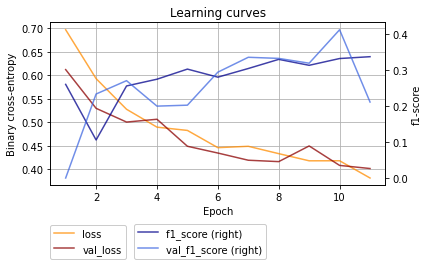

Model: cnn_basemodel_1


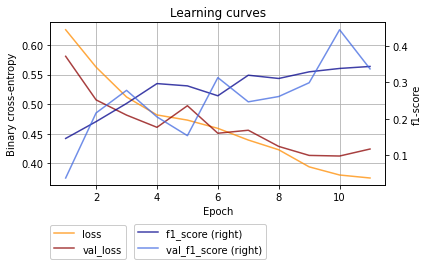

Model: cnn_basemodel_2


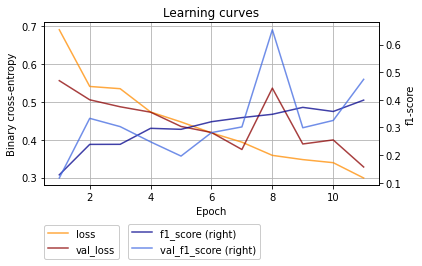

Model: cnn_basemodel_3


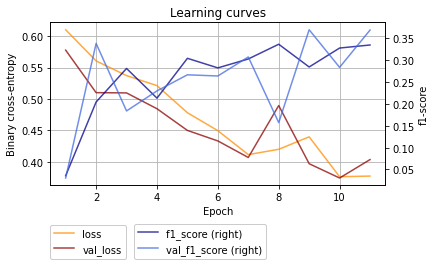

Model: cnn_basemodel_4


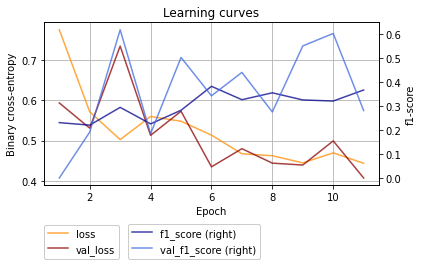

Model: cnn_basemodel_5


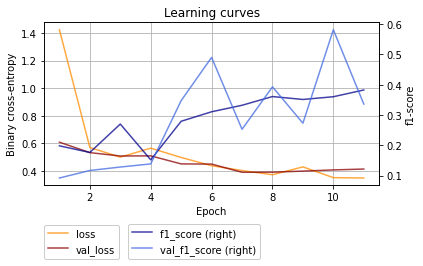

Model: cnn_basemodel_6


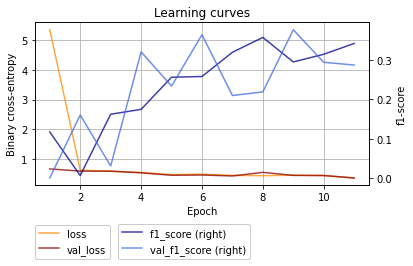

Model: cnn_basemodel_7


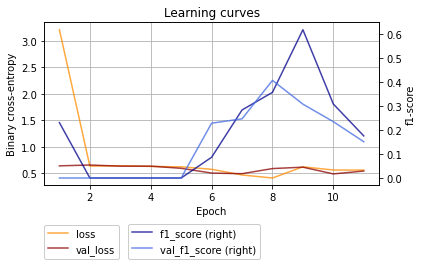

In [60]:
# Plot the learning curves 

i = 0
for hist in train_hist:
  print("Model:", models[i])
  hist_results_f1s(hist)
  plt.show()
  i= i + 1

### Model scores

In [62]:
# Model scores

i = 0
for hist in train_hist:
  highest_val_f1_score = max(hist.history['val_f1_score'])
  highest_train_f1_score = max(hist.history['f1_score'])
  print("Model:", models[i], '->', 'val_f1_score =',highest_val_f1_score, ',', 'train_f1_score =',highest_train_f1_score)
  i = i + 1

Model: cnn_basemodel_0 -> val_f1_score = 0.4123252034187317 , train_f1_score = 0.33739274740219116
Model: cnn_basemodel_1 -> val_f1_score = 0.4442509114742279 , train_f1_score = 0.3436816334724426
Model: cnn_basemodel_2 -> val_f1_score = 0.6538375616073608 , train_f1_score = 0.39903128147125244
Model: cnn_basemodel_3 -> val_f1_score = 0.3700065314769745 , train_f1_score = 0.33680614829063416
Model: cnn_basemodel_4 -> val_f1_score = 0.6178896427154541 , train_f1_score = 0.382081001996994
Model: cnn_basemodel_5 -> val_f1_score = 0.581260085105896 , train_f1_score = 0.38231977820396423
Model: cnn_basemodel_6 -> val_f1_score = 0.3768741190433502 , train_f1_score = 0.35737594962120056
Model: cnn_basemodel_7 -> val_f1_score = 0.4067106544971466 , train_f1_score = 0.6176323294639587


### Save the models

In [63]:
# Save the models

cnn_basemodel_0.save('cnn_basemodel_0.h5')
cnn_basemodel_1.save('cnn_basemodel_1.h5')
cnn_basemodel_2.save('cnn_basemodel_2.h5')
cnn_basemodel_3.save('cnn_basemodel_3.h5')
cnn_basemodel_4.save('cnn_basemodel_4.h5')
cnn_basemodel_5.save('cnn_basemodel_5.h5')
cnn_basemodel_6.save('cnn_basemodel_6.h5')
cnn_basemodel_7.save('cnn_basemodel_7.h5')

https://www.tensorflow.org/guide/keras/save_and_serialize


WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.

### The chosen model - Hyper parameter tune

https://www.kaggle.com/code/theainerd/the-hitchiker-s-guide-to-cnn-with-fine-tuning


https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks


https://towardsdatascience.com/a-walkthrough-of-convolutional-neural-network-7f474f91d7bd


https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

For the chosen model fine tune and compare with models with data augmentation and regularization

## Hyperparameter for Best model

### Hiper Parameter Tuning Parameters


In [64]:
# Common attributes
epochs = 100
early_stop = EarlyStopping(patience=25, monitor='val_f1_score', mode='auto', restore_best_weights=True)

### Hiper Parameter Tuning models definition

###### cnn_hptmodel_0

In [65]:
# Chosen model with BatchNormalization and Dropout layers between each convolutional layer

tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_0 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.BatchNormalization(),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),

                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_0.build(input_shape)

cnn_hptmodel_0.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 batch_normalization (BatchN  (128, 128, 128, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d_22 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_22 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_23 (MaxPoolin  (128, 32, 32, 128)      

##### cnn_hptmodel_1

In [66]:
# Chosen model with BatchNormalization and Dropout layers between each convolutional layer

tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_1 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.BatchNormalization(),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),

                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_1.build(input_shape)

cnn_hptmodel_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 batch_normalization_1 (Batc  (128, 128, 128, 3)       12        
 hNormalization)                                                 
                                                                 
 conv2d_25 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_25 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (128, 64, 64, 64)         0         
                                                                 
 conv2d_26 (Conv2D)          (128, 64, 64, 128)       

##### cnn_hptmodel_2


In [67]:
# Chosen model with BatchNormalization and Dropout layers between each convolutional layer

tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_2 = Sequential([
                    layers.Rescaling(1.0 / 255),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.BatchNormalization(),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.BatchNormalization(),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.Dropout(0.3),

                    layers.BatchNormalization(),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_2.build(input_shape)

cnn_hptmodel_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (128, 128, 128, 3)        0         
                                                                 
 conv2d_28 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_28 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (128, 64, 64, 64)         0         
                                                                 
 batch_normalization_2 (Batc  (128, 64, 64, 64)        256       
 hNormalization)                                                 
                                                                 
 conv2d_29 (Conv2D)          (128, 64, 64, 128)      

##### cnn_hptmodel_3

In [68]:
# Chosen model with BatchNormalization and Dropout layers between each convolutional layer

tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_3 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.BatchNormalization(),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),
                    
                    layers.BatchNormalization(),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.BatchNormalization(),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),

                    layers.BatchNormalization(),
                    layers.GlobalMaxPooling2D(),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_3.build(input_shape)

cnn_hptmodel_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (128, 128, 128, 3)        0         
                                                                 
 batch_normalization_5 (Batc  (128, 128, 128, 3)       12        
 hNormalization)                                                 
                                                                 
 conv2d_31 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 dropout_8 (Dropout)         (128, 128, 128, 64)       0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (128, 64, 64, 64)      

##### cnn_hptmodel_5

In [69]:
# Chosen model with BatchNormalization and Dropout layers between each convolutional layer

tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_5 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.BatchNormalization(),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding,
                                  kernel_regularizer=regularizers.L2(1e-4),
                                  bias_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.BatchNormalization(),
                    
                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding,
                                  kernel_regularizer=regularizers.L2(1e-4),
                                  bias_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.BatchNormalization(),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding,
                                  kernel_regularizer=regularizers.L2(1e-4),
                                  bias_regularizer=regularizers.L2(1e-4)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),
                    
                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', 
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu',
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_5.build(input_shape)

##### cnn_hptmodel_6

In [70]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to model_5 with
# and additional dense layer and neurons 2048, 2048 and 2

#tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_6 = Sequential([
                    layers.Rescaling(1.0 / 255),
                    layers.BatchNormalization(),
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.5),
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.BatchNormalization(),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.5),                   
                    layers.MaxPooling2D(pool_size=pool_size),
                    layers.BatchNormalization(),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.5),                 
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_6.build(input_shape)

cnn_hptmodel_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (128, 128, 128, 3)        0         
                                                                 
 batch_normalization_12 (Bat  (128, 128, 128, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 dropout_14 (Dropout)        (128, 128, 128, 64)       0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (128, 64, 64, 64)      

##### cnn_hptmodel_7

In [71]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to model_5 with
# and additional dense layer and neurons 2048, 2048 and 2

#tf.keras.utils.set_random_seed(seed)

cnn_hptmodel_7 = Sequential([
                    layers.Rescaling(1.0 / 255),
                    layers.BatchNormalization(),
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.3),
                    layers.MaxPooling2D(pool_size=pool_size),
  
                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.3),                   
                    layers.MaxPooling2D(pool_size=pool_size),
     
                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding, kernel_regularizer=regularizers.L2(0.001)),
                    layers.Dropout(0.3),                 
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=2048, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_hptmodel_7.build(input_shape)

cnn_hptmodel_7.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (128, 128, 128, 3)        0         
                                                                 
 batch_normalization_15 (Bat  (128, 128, 128, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_40 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 dropout_17 (Dropout)        (128, 128, 128, 64)       0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (128, 64, 64, 128)      

#### Compile Models

In [72]:
# Compile Models
cnn_hptmodel_0.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_1.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_2.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_3.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_5.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_6.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_hptmodel_7.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])

### Training Hiper Parameter Tuning models

In [73]:
# Model training
start = time.time()
history_hpt_0 = cnn_hptmodel_0.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 5s 155ms/step - loss: 8.5548 - f1_score: 0.3817 - recall_8: 0.4023 - precision_8: 0.3296 - accuracy: 0.5367 - val_loss: 1.2708 - val_f1_score: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 73ms/step - loss: 1.2281 - f1_score: 0.0000e+00 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - accuracy: 0.6728 - val_loss: 1.1969 - val_f1_score: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 71ms/step - loss: 1.1750 - f1_score: 0.0000e+00 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - accuracy: 0.6728 - val_loss: 1.1437 - val_f1_score: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 71ms/step - loss: 1.1184 - f1_score: 0.0000e+00 - recall_8: 0

In [74]:
# Model training
start = time.time()
history_hpt_1 = cnn_hptmodel_1.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 3s 146ms/step - loss: 14.1961 - f1_score: 0.4103 - recall_9: 0.4062 - precision_9: 0.3185 - accuracy: 0.5214 - val_loss: 1.4439 - val_f1_score: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_precision_9: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 74ms/step - loss: 1.4488 - f1_score: 0.0000e+00 - recall_9: 0.0000e+00 - precision_9: 0.0000e+00 - accuracy: 0.6728 - val_loss: 1.4345 - val_f1_score: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_precision_9: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 75ms/step - loss: 1.4053 - f1_score: 0.0000e+00 - recall_9: 0.0000e+00 - precision_9: 0.0000e+00 - accuracy: 0.6728 - val_loss: 1.3621 - val_f1_score: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_precision_9: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 74ms/step - loss: 1.3335 - f1_score: 0.0000e+00 - recall_9: 

In [75]:
# Model training
start = time.time()
history_hpt_2 = cnn_hptmodel_2.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 5s 219ms/step - loss: 4.1962 - f1_score: 0.3751 - recall_10: 0.3867 - precision_10: 0.4410 - accuracy: 0.6390 - val_loss: 1.4966 - val_f1_score: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 68ms/step - loss: 1.4069 - f1_score: 0.4280 - recall_10: 0.6055 - precision_10: 0.7143 - accuracy: 0.7917 - val_loss: 2.2644 - val_f1_score: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 69ms/step - loss: 1.4218 - f1_score: 0.4350 - recall_10: 0.6699 - precision_10: 0.7885 - accuracy: 0.8332 - val_loss: 2.2039 - val_f1_score: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 68ms/step - loss: 1.3165 - f1_score: 0.4274 - recall_10: 0.7402 - precisi

In [76]:
# Model training
start = time.time()
history_hpt_3 = cnn_hptmodel_3.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 4s 131ms/step - loss: 4.2806 - f1_score: 0.3573 - recall_11: 0.3828 - precision_11: 0.3544 - accuracy: 0.5700 - val_loss: 2.1422 - val_f1_score: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_precision_11: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 77ms/step - loss: 0.8343 - f1_score: 0.3477 - recall_11: 0.4199 - precision_11: 0.5570 - accuracy: 0.7010 - val_loss: 0.8323 - val_f1_score: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_precision_11: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 78ms/step - loss: 0.6621 - f1_score: 0.3568 - recall_11: 0.5293 - precision_11: 0.8187 - accuracy: 0.8077 - val_loss: 0.9209 - val_f1_score: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_precision_11: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 78ms/step - loss: 0.6190 - f1_score: 0.3789 - recall_11: 0.5762 - precisi

In [77]:
# Model training
start = time.time()
history_hpt_5 = cnn_hptmodel_5.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 4s 158ms/step - loss: 67.3948 - f1_score: 0.3770 - recall_12: 0.3945 - precision_12: 0.3274 - accuracy: 0.5367 - val_loss: 1.4332 - val_f1_score: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_precision_12: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 84ms/step - loss: 2.2220 - f1_score: 0.3832 - recall_12: 0.4023 - precision_12: 0.3665 - accuracy: 0.5770 - val_loss: 1.5988 - val_f1_score: 0.0670 - val_recall_12: 0.0310 - val_precision_12: 0.2222 - val_accuracy: 0.6463
Epoch 3/100
13/13 [==============================] - 1s 83ms/step - loss: 1.5239 - f1_score: 0.4022 - recall_12: 0.5312 - precision_12: 0.6282 - accuracy: 0.7438 - val_loss: 1.5952 - val_f1_score: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_precision_12: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 84ms/step - loss: 1.4108 - f1_score: 0.3398 - recall_12: 0.4805 - precision_12: 0.75

In [78]:
# Model training
start = time.time()
history_hpt_6 = cnn_hptmodel_6.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 4s 167ms/step - loss: 78.3071 - f1_score: 0.2325 - recall_13: 0.2266 - precision_13: 0.3222 - accuracy: 0.5911 - val_loss: 2.3979 - val_f1_score: 1.0000 - val_recall_13: 1.0000 - val_precision_13: 0.3282 - val_accuracy: 0.3282
Epoch 2/100
13/13 [==============================] - 2s 103ms/step - loss: 5.2336 - f1_score: 0.3377 - recall_13: 0.3496 - precision_13: 0.3416 - accuracy: 0.5668 - val_loss: 1.8580 - val_f1_score: 0.0989 - val_recall_13: 0.0620 - val_precision_13: 0.5714 - val_accuracy: 0.6768
Epoch 3/100
13/13 [==============================] - 2s 98ms/step - loss: 1.8062 - f1_score: 0.3265 - recall_13: 0.4453 - precision_13: 0.6746 - accuracy: 0.7482 - val_loss: 1.9022 - val_f1_score: 0.9495 - val_recall_13: 0.8295 - val_precision_13: 0.2997 - val_accuracy: 0.3079
Epoch 4/100
13/13 [==============================] - 2s 95ms/step - loss: 1.5432 - f1_score: 0.4051 - recall_13: 0.6406 - precision_13: 0.8283 - accuracy: 0.8390 -

In [79]:
# Model training
start = time.time()
history_hpt_7 = cnn_hptmodel_7.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
13/13 [==============================] - 4s 169ms/step - loss: 30.0798 - f1_score: 0.1907 - recall_14: 0.2109 - precision_14: 0.3661 - accuracy: 0.6224 - val_loss: 1.5328 - val_f1_score: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00 - val_accuracy: 0.6718
Epoch 2/100
13/13 [==============================] - 1s 82ms/step - loss: 1.5145 - f1_score: 0.0765 - recall_14: 0.0820 - precision_14: 0.7636 - accuracy: 0.6914 - val_loss: 1.5538 - val_f1_score: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00 - val_accuracy: 0.6718
Epoch 3/100
13/13 [==============================] - 1s 83ms/step - loss: 1.4452 - f1_score: 0.2717 - recall_14: 0.3555 - precision_14: 0.6212 - accuracy: 0.7182 - val_loss: 1.4679 - val_f1_score: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00 - val_accuracy: 0.6718
Epoch 4/100
13/13 [==============================] - 1s 82ms/step - loss: 1.2959 - f1_score: 0.3291 - recall_14: 0.4668 - precis

### Visualize Model results 

In [80]:
# History and Models list
train_hist_hpt = [history_hpt_0, history_hpt_1, history_hpt_2, history_hpt_3, history_hpt_5, history_hpt_6 ,history_hpt_7]
models_hpt = ["cnn_hptmodel_0", "cnn_hptmodel_1", "cnn_hptmodel_2", "cnn_hptmodel_3", "cnn_hptmodel_5","cnn_hptmodel_6", "cnn_hptmodel_7"]

Model: cnn_hptmodel_0


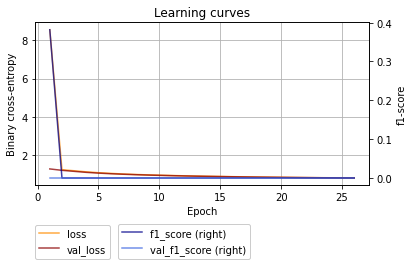

Model: cnn_hptmodel_1


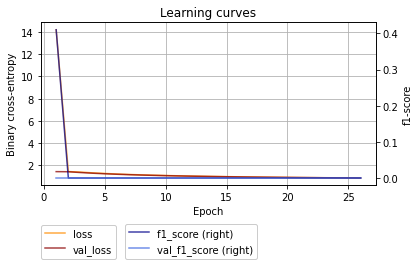

Model: cnn_hptmodel_2


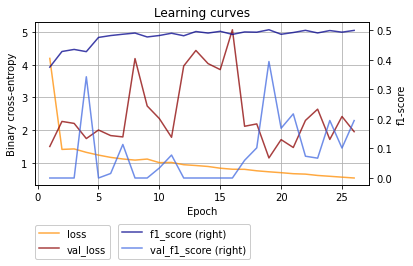

Model: cnn_hptmodel_3


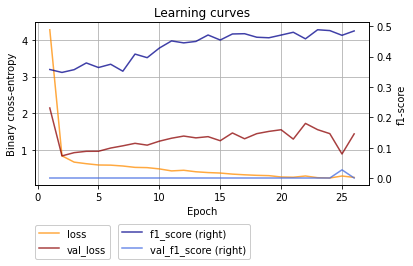

Model: cnn_hptmodel_5


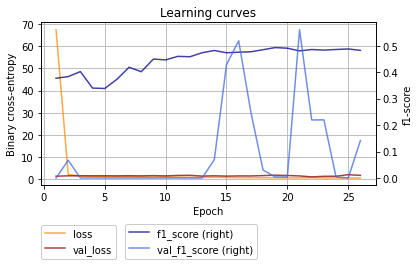

Model: cnn_hptmodel_6


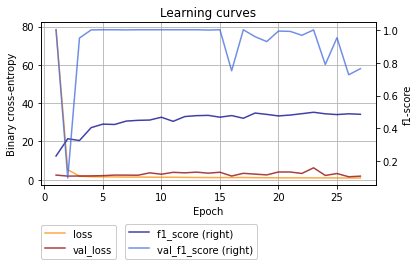

Model: cnn_hptmodel_7


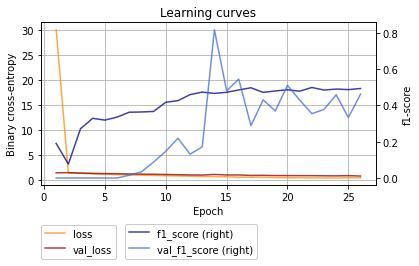

In [81]:
# Plot the learning curves
i = 0
for hist in train_hist_hpt:
  print("Model:", models_hpt[i])
  hist_results_f1s(hist)
  plt.show()
  i= i + 1

In [88]:
# Model scores

i = 0
for hist in train_hist_hpt:
  highest_val_f1_score = max(hist.history['val_f1_score'])
  highest_train_f1_score = max(hist.history['f1_score'])
  print("Model:", models_hpt[i], '->', 'val_f1_score =',highest_val_f1_score, ',', 'train_f1_score =',highest_train_f1_score)
  i = i + 1

Model: cnn_hptmodel_0 -> val_f1_score = 0.0 , train_f1_score = 0.381700724363327
Model: cnn_hptmodel_1 -> val_f1_score = 0.0 , train_f1_score = 0.4103074371814728
Model: cnn_hptmodel_2 -> val_f1_score = 0.39399662613868713 , train_f1_score = 0.5015641450881958
Model: cnn_hptmodel_3 -> val_f1_score = 0.026834994554519653 , train_f1_score = 0.488286554813385
Model: cnn_hptmodel_5 -> val_f1_score = 0.5602757334709167 , train_f1_score = 0.4928833842277527
Model: cnn_hptmodel_6 -> val_f1_score = 1.0 , train_f1_score = 0.49842217564582825
Model: cnn_hptmodel_7 -> val_f1_score = 0.8173015713691711 , train_f1_score = 0.4990786910057068


## Transfer Learning

In [83]:
# Delete all waldo 128 bw images
dir = '/content/wheres-waldo/Hey-Waldo/128-bw/waldo'
for file in os.scandir(dir):
    os.remove(file.path)

In [84]:
# Define a function for the grayscale in TensorFlow
import tensorflow as tf

def grayscale(image):
  # Convert the image to grayscale using TensorFlow's image grayscale function
  gray_image = tf.image.rgb_to_grayscale(image)
  
  return gray_image

In [85]:
datagenbw = ImageDataGenerator(preprocessing_function=grayscale)

In [86]:
# Apply transformations and save each image to the output folder
folder = '/content/wheres-waldo/Hey-Waldo/128/waldo/'

#image_list = []
for j in os.listdir(folder):
  img = load_img(folder+j)  # this is a PIL image
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  # the .flow() command below generates batches of randomly transformed images
  # and saves the results to the `preview/` directory
  i = 0
  for batch in datagenbw.flow(
      x, batch_size=1, 
      save_to_dir='/content/wheres-waldo/Hey-Waldo/128-bw/waldo',
      save_prefix='new_waldo', 
      save_format='jpeg'):
    i += 1
    if i > 3:
        break  # otherwise the generator would loop indefinitely
  
  #image_list.append(x)

IndexError: ignored

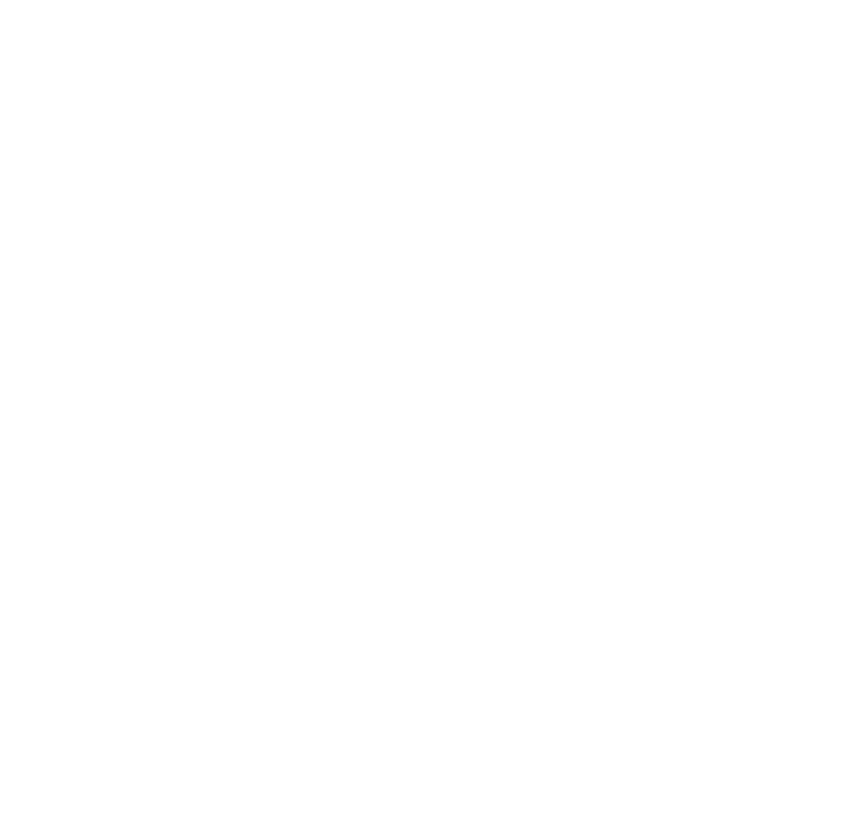

In [87]:
# Display the transformations applied by the data augmentation process

import random
from PIL import Image 

#newaldos_folder = '/content/sample_data/Waldo_test' #to change to 'wheres-waldo/Hey-Waldo/128/waldo/'
newaldos_folder = '/content/wheres-waldo/Hey-Waldo/128-bw/waldo'

images = []
#for folder in os.listdir(nwaldos_folder):
for image in os.listdir(newaldos_folder + '/'):
  images.append(os.path.join(newaldos_folder, image))

plt.figure(1, figsize=(15, 15))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  #plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [ ]:
# Choose a pre-trained model
#base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 1))

# Load the model (ESTA é a opção a utilizar)
model = keras.models.load_model('path/to/model.h5', include_top=True, input_shape=(128, 128, 1))

# explicação para incluir a Top Layer e a input shape facil 

# Load the model
#model = keras.models.load_model('path/to/model.h5')

In [ ]:
# Freeze the layers
base_model.trainable = False

In [ ]:
# Add a new output layer
model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy']])

In [ ]:
# Load the data
data_dir = 'path/to/dataset' # alterar para a pasta black and white (so com as imagens iniciais de 128 ou fazemos para as nossas imagens todas como fizemos)
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=128, class_mode='binary')

#Batch_size pensar em alterar isto para menos batch size

In [ ]:
# Train the model using the generator
model.fit(train_generator, epochs=10)

# Train the model using the generator
start = time.time()
transfer_learning = model.fit(train_generator, epochs=10, #possivelmente alterar o número de epochs para os definidos anteriormente
                              validation_data=validation_generator,
                              callbacks=[keras.callbacks.EarlyStopping(patience=2)])

print("Training time: {:.4f}s".format(time.time() - start))

In [ ]:
print("Model:", "transfer_learning")
hist_results_acc(transfer_learning)
plt.show()